---
title: "Revision plots, IER manuscript"
format: 
  html:
    code-fold: false
    theme: journal
    embed-resources: true
jupyter: R
author: "Rasmus Olofzon"
toc: true
toc-expand: true
fig-cap-location: top
---

---


## Methods

### Differentially expressed genes (DEG)

The samples were first compared cell cycle phase-wise, since the dataset showed clear separation based on phase classification, but its structure otherwise made biological sense. In the UMAP the two ice conditions co-located very clearly, which prompted the notion of treating them as one for the DEG analysis. This was corroborated by a DEG testing between the two ice conditions, which for the samples as wholes yielded three DEGs, non with significant p-values. Phase-wise no DEGs were found.

Based off of that, three comparisons were carried out:

1. 37c _with_ triptolide VS ice
2. 37c _without_ triptolide VS ice
3. 37c _without_ triptolide VS 37c _without_ triptolide

The comparisons were first made cell cycle phase-wise (G1, G2M, S), then the intersection of the found DEGs was taken. This would give the differentially expressed genes that most characterizes a given condition, without cell cycle-specific genes.

The DEG testing was performed with Seurat's `FindMarkers` function, testing performed only on highly variable genes (HVGs). The intersection was taken with R's `intersect` function for sets.

### Gene signatures

The gene signature scores were calculated and visualized similar to the procedure for the IER signature.

---

# Setup

In [2]:
library(Seurat)
library(stringr)
library(dplyr)
library(ggplot2)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
library(tidyr)
library(dplyr)
library(viridis)

Loading required package: viridisLite



In [4]:
library(patchwork)

In [5]:
sobj <- readRDS("../data/processed/seurat_object_w_stress_sig.rds")

In [6]:
# cols_features <- c("moccasin", "darkslategray")
cols_features <- c("lightgray", "red3")


In [7]:
phases <- list("G1", "G2M", "S")
names(phases) <- phases
phases

$G1
[1] "G1"

$G2M
[1] "G2M"

$S
[1] "S"

---

# Visualization of dataset with conditions, for reference

Metadata:

In [8]:
#| label: tbl-metadata
#| tbl-cap: "Metadata for dataset"
sobj[[]] %>% head

orig.ident     nCount_RNA nFeature_RNA nCount_ADT
AAACCCAAGAGACAAG-1 DB_AKC_citeseq 11976      3437         128       
AAACCCAAGAGTGAAG-1 DB_AKC_citeseq 21028      5475          54       
AAACCCAAGCGAAACC-1 DB_AKC_citeseq 10688      2813          56       
AAACCCAAGGTAAAGG-1 DB_AKC_citeseq 10627      3677          68       
AAACCCAAGGTCTACT-1 DB_AKC_citeseq 16865      3915         106       
AAACCCAAGTCGGCCT-1 DB_AKC_citeseq 13939      4192          60       
                   nFeature_ADT nCount_HTO nFeature_HTO percent.mt hto 
AAACCCAAGAGACAAG-1 4             32        3            2.104208   HTO2
AAACCCAAGAGTGAAG-1 4            108        4            2.425338   HTO3
AAACCCAAGCGAAACC-1 3             87        2            4.519087   HTO4
AAACCCAAGGTAAAGG-1 4             79        4            2.888868   HTO1
AAACCCAAGGTCTACT-1 4             99        2            2.514082   HTO4
AAACCCAAGTCGGCCT-1 3             75        2            3.285745   HTO3
                   sample   ⋯ buffer_treatment incubation_method S.Score   
AAACCCAAGAGACAAG-1 37c_no_t ⋯ no_triptolide    37c               -0.2740383
AAACCCAAGAGTGAAG-1 ice_t    ⋯ with_triptolide  ice                0.2386460
AAACCCAAGCGAAACC-1 37c_t    ⋯ with_triptolide  37c               -0.1966232
AAACCCAAGGTAAAGG-1 ice_no_t ⋯ no_triptolide    ice               -0.1555948
AAACCCAAGGTCTACT-1 37c_t    ⋯ with_triptolide  37c                0.2038750
AAACCCAAGTCGGCCT-1 ice_t    ⋯ with_triptolide  ice               -0.3008664
                   G2M.Score   Phase old.ident RNA_snn_res.0.8 seurat_clusters
AAACCCAAGAGACAAG-1 -0.19990412 G1    HTO2      0               0              
AAACCCAAGAGTGAAG-1 -0.01205648 S     HTO3      1               1              
AAACCCAAGCGAAACC-1 -0.14132145 G1    HTO4      5               5              
AAACCCAAGGTAAAGG-1 -0.21232288 G1    HTO1      2               2              
AAACCCAAGGTCTACT-1  0.17149954 S     HTO4      7               7              
AAACCCAAGTCGGCCT-1 -0.25975436 G1    HTO3      2               2              
                   stress_signature1 is_stressed 
AAACCCAAGAGACAAG-1  0.19599848       stressed    
AAACCCAAGAGTGAAG-1 -0.10710847       not_stressed
AAACCCAAGCGAAACC-1 -0.04234327       not_stressed
AAACCCAAGGTAAAGG-1 -0.04919840       not_stressed
AAACCCAAGGTCTACT-1 -0.08366769       not_stressed
AAACCCAAGTCGGCCT-1 -0.09381362       not_stressed

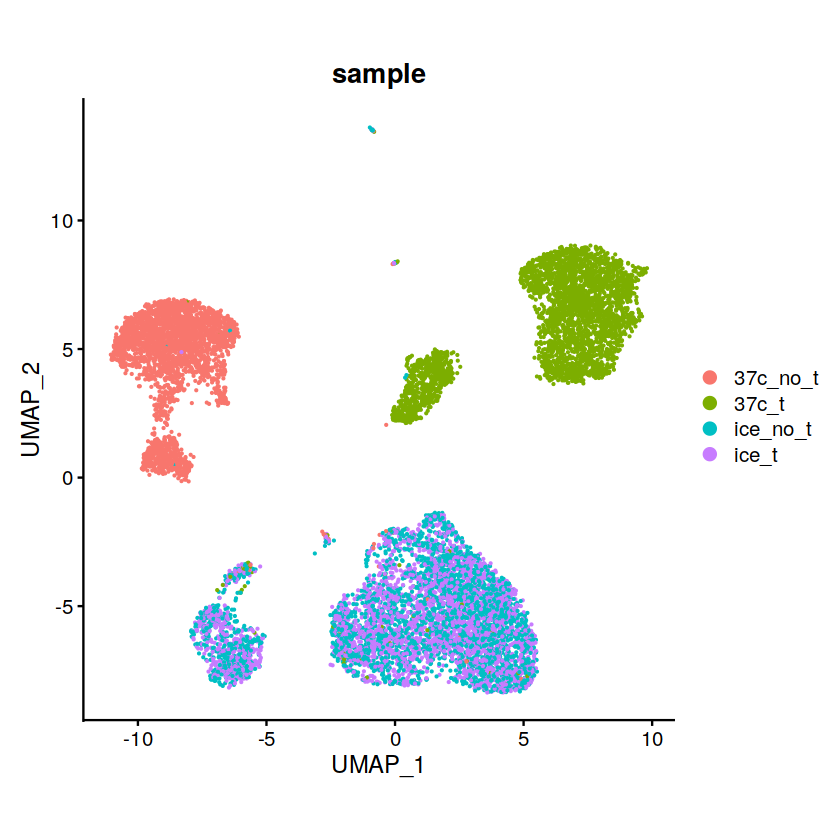

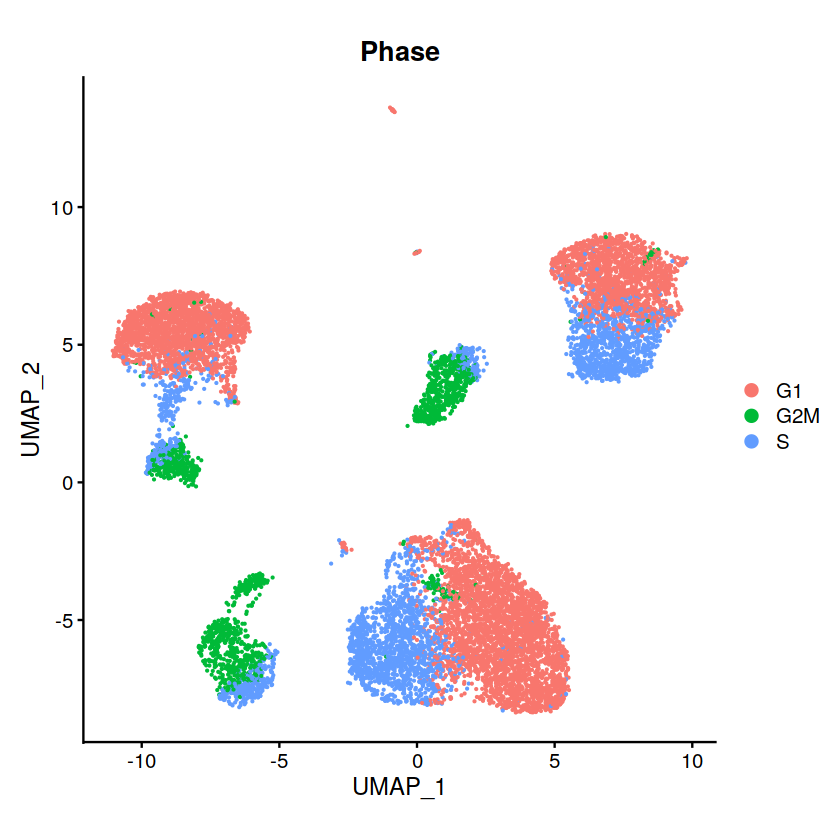

In [9]:
#| label: fig-dimplots
#| fig-cap: "UMAP coloured on metadata"
#| fig-subcap: 
#|   - "Coloured on condition/sample"
#|   - "Coloured on cell cycle phases"
#| layout-ncol: 2
DimPlot(sobj, group.by = "sample") + coord_fixed()
DimPlot(sobj, group.by = "Phase") + coord_fixed()

In [10]:
df <- table(sobj[[]][,c("sample", "Phase")]) %>% as.data.frame.matrix #%>% rbind(
# table(sobj[[]][,c("sample")]) %>% as.list
# )
df

G1   G2M S   
37c_no_t 2164 334  375
37c_t    1799 608 1173
ice_no_t 1825 351  872
ice_t    1760 360  945

In [11]:
df[["sample"]] <- table(sobj[["sample"]]) %>% as.list %>% as.numeric
df

G1   G2M S    sample
37c_no_t 2164 334  375 2873  
37c_t    1799 608 1173 3580  
ice_no_t 1825 351  872 3048  
ice_t    1760 360  945 3065

In [12]:
df <- df %>% mutate(
    G1_frac = round(G1 / sample, digits = 2),
    G2M_frac = round(G2M / sample, digits = 2),
    S_frac = round(S / sample, digits = 2),
)
df

G1   G2M S    sample G1_frac G2M_frac S_frac
37c_no_t 2164 334  375 2873   0.75    0.12     0.13  
37c_t    1799 608 1173 3580   0.50    0.17     0.33  
ice_no_t 1825 351  872 3048   0.60    0.12     0.29  
ice_t    1760 360  945 3065   0.57    0.12     0.31

In [13]:
#| label: tbl-phase-sample
#| tbl-cap: "Cell cycle phase classification distribution per condition"
df <- table(sobj[[]][,c("sample", "Phase")]) %>% as.data.frame.matrix #%>% rbind(
# table(sobj[[]][,c("sample")]) %>% as.list
# )
df
df <- df %>% tibble::rownames_to_column(var = "sample") %>% pivot_longer(cols = c("G1", "G2M", "S"), names_to = "phase", values_to="n_cells")
df

G1   G2M S   
37c_no_t 2164 334  375
37c_t    1799 608 1173
ice_no_t 1825 351  872
ice_t    1760 360  945

sample   phase n_cells
1  37c_no_t G1    2164   
2  37c_no_t G2M    334   
3  37c_no_t S      375   
4  37c_t    G1    1799   
5  37c_t    G2M    608   
6  37c_t    S     1173   
7  ice_no_t G1    1825   
8  ice_no_t G2M    351   
9  ice_no_t S      872   
10 ice_t    G1    1760   
11 ice_t    G2M    360   
12 ice_t    S      945

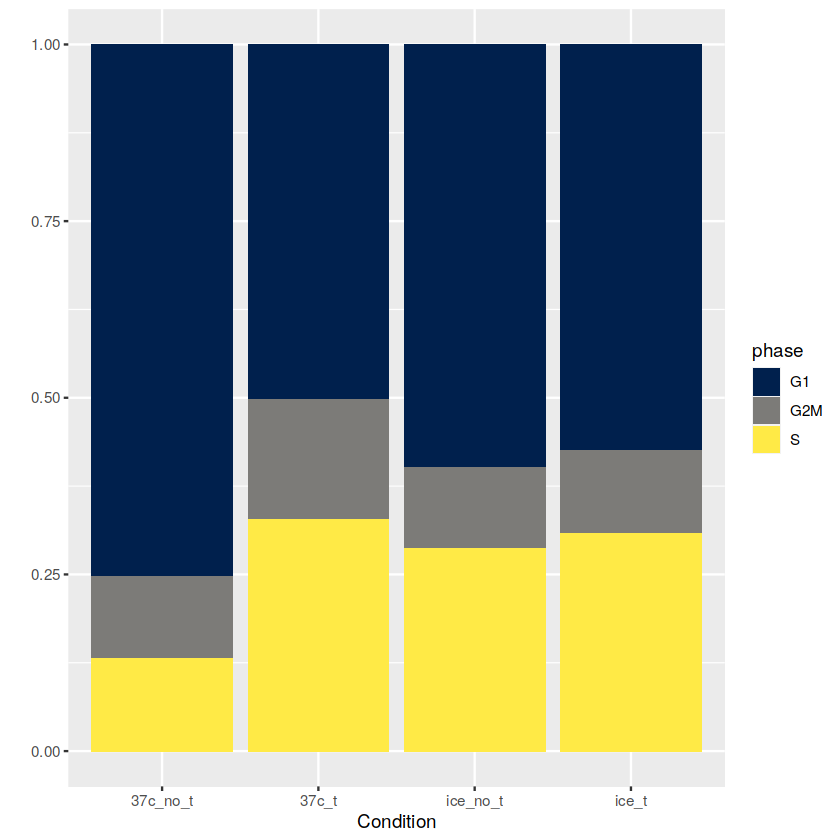

In [14]:
ggplot(df, aes(fill=phase, y=n_cells, x=sample)) + 
    geom_bar(position="fill", stat="identity") +
    scale_fill_viridis(discrete = T, option = "cividis") +
    ylab("") +
    xlab("Condition")
ggsave(last_plot(), filename = "plots/cc_phase_distribution_per_condition.svg", device = "svg", units = "in", width = 6, height = 6)

# Compare ice conditions

In [15]:
WhichCells(sobj, expr = sample == "ice_t" & Phase == "S") %>% length

[1] 945

In [16]:
Idents(sobj) <- "sample"
DefaultAssay(sobj) <- "RNA"
degs <- FindMarkers(
    sobj,
    ident.1 = "ice_t",
    ident.2 = "ice_no_t",
    assay = "RNA",
    features = VariableFeatures(sobj)
) %>% arrange(desc(avg_log2FC))
degs

p_val      avg_log2FC pct.1 pct.2 p_val_adj
C77080 0.21988781 -0.2606570 0.285 0.293 1        
Ighm   0.05580379 -0.6127761 0.530 0.536 1        
Igkc   0.32788650 -0.6539980 0.457 0.464 1

So, only three DEGs, with insignificant p-values. Should probably be a good argument for treating them as one for this.

In [49]:
get_degs_cc_wise <- \(idents = "sample", group_1 = "ice_t", group_2 = c("ice_t", "ice_no_t"), cc_phase = "S") {
    Idents(sobj) <- idents
    DefaultAssay(sobj) <- "RNA"

    # extract cell groups:
    cells_1 = WhichCells(sobj, expr = sample %in% group_1 & Phase == cc_phase)
    cells_2 = WhichCells(sobj, expr = sample %in% group_2 & Phase == cc_phase)
    foo_1 <- table(sobj[[]][cells_1,c("sample", "Phase")]) %>% as.data.frame.matrix
    foo_2 <- table(sobj[[]][cells_2,c("sample", "Phase")]) %>% as.data.frame.matrix

    # double-check that the correct cell groups are extracted,
    # will throw an error and fail if they are not correct:
    stopifnot(phase_distributions[group_2, cc_phase] == foo_2[group_2, cc_phase])

    degs <- FindMarkers(
        sobj[["RNA"]],
        cells.1 = cells_1,
        cells.2 = cells_2,
        features = VariableFeatures(sobj)
    ) %>% arrange(desc(avg_log2FC))
    degs %>% return
}

In [50]:
get_degs_cc_wise(group_1 = "ice_t", group_2 = "ice_no_t", cc_phase = "S")
get_degs_cc_wise(group_1 = "ice_t", group_2 = "ice_no_t", cc_phase = "G1")
get_degs_cc_wise(group_1 = "ice_t", group_2 = "ice_no_t", cc_phase = "G2M")

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


avg_log2FC pct.1 pct.2

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


avg_log2FC pct.1 pct.2

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


avg_log2FC pct.1 pct.2

So yeah, no DEGs at all doing it phase-wise.

# Compare 37c conditions

In [51]:
sobj[[]][["sample"]] %>% unique

[1] "37c_no_t" "ice_t"    "37c_t"    "ice_no_t"

- 37c_t vs ice
- 37c_no_t vs ice
- 37c_t vs 37c_no_t

In [52]:
ice <- c("ice_t", "ice_no_t")
comparisons <- list(
    "37c_t" = list("37c_t", ice),
    "37c_no_t" = list("37c_no_t", ice),
    "37c_t_vs_no_t" = list("37c_t", "37c_no_t")
)
# degs <- list(
#     "37c_t" = "",
#     "37c_no_t" = "",
#     "37c_t_vs_no_t" = ""
# )
comparisons
# degs

$`37c_t`
$`37c_t`[[1]]
[1] "37c_t"

$`37c_t`[[2]]
[1] "ice_t"    "ice_no_t"


$`37c_no_t`
$`37c_no_t`[[1]]
[1] "37c_no_t"

$`37c_no_t`[[2]]
[1] "ice_t"    "ice_no_t"


$`37c_t_vs_no_t`
$`37c_t_vs_no_t`[[1]]
[1] "37c_t"

$`37c_t_vs_no_t`[[2]]
[1] "37c_no_t"

In [53]:
get_degs_cc_wise(group_1 = comparisons[["37c_t"]][[1]], group_2 = comparisons[["37c_t"]][[2]], cc_phase = "S") %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
4933406J09Rik  0.000000e+00 1.0673711  0.882 0.111  0.000000e+00
Gm40841        0.000000e+00 0.8333755  0.777 0.034  0.000000e+00
Bcl2l14       4.972059e-238 0.8190220  0.552 0.038 1.605229e-233
Pex1          2.962626e-229 0.6778770  0.708 0.216 9.564839e-225
Sh2b2         8.265819e-252 0.6284175  0.713 0.173 2.668620e-247
Gm28403       1.804430e-224 0.5924536  0.609 0.087 5.825601e-220

In [28]:
phase_distributions <- table(sobj[[]][,c("sample", "Phase")]) %>% as.data.frame.matrix #%>% rbind(
phase_distributions

G1   G2M S   
37c_no_t 2164 334  375
37c_t    1799 608 1173
ice_no_t 1825 351  872
ice_t    1760 360  945

In [43]:
degs <- lapply(comparisons, FUN = \(comp) {
    lapply(phases, FUN = \(phase) {
        group_1 <- comp[[1]]
        group_2 <- comp[[2]]
        print(group_1)
        print(group_2)
        print(phase)
        cells_1 = WhichCells(sobj, expr = sample %in% group_1 & Phase == phase)
        cells_2 = WhichCells(sobj, expr = sample %in% group_2 & Phase == phase)
        print(length(cells_1))
        print(length(cells_2))
        foo_1 <- table(sobj[[]][cells_1,c("sample", "Phase")]) %>% as.data.frame.matrix
        foo_2 <- table(sobj[[]][cells_2,c("sample", "Phase")]) %>% as.data.frame.matrix
        print(foo_1)
        print(foo_2)
        stopifnot(phase_distributions[group_2, phase] == foo_2[group_2, phase])
        print("------")
    })
})

[1] "37c_t"
[1] "ice_t"    "ice_no_t"
[1] "G1"
[1] 1799
[1] 3585
        G1
37c_t 1799
           G1
ice_no_t 1825
ice_t    1760
[1] "------"
[1] "37c_t"
[1] "ice_t"    "ice_no_t"
[1] "G2M"
[1] 608
[1] 711
      G2M
37c_t 608
         G2M
ice_no_t 351
ice_t    360
[1] "------"
[1] "37c_t"
[1] "ice_t"    "ice_no_t"
[1] "S"
[1] 1173
[1] 1817
         S
37c_t 1173
           S
ice_no_t 872
ice_t    945
[1] "------"
[1] "37c_no_t"
[1] "ice_t"    "ice_no_t"
[1] "G1"
[1] 2164
[1] 3585
           G1
37c_no_t 2164
           G1
ice_no_t 1825
ice_t    1760
[1] "------"
[1] "37c_no_t"
[1] "ice_t"    "ice_no_t"
[1] "G2M"
[1] 334
[1] 711
         G2M
37c_no_t 334
         G2M
ice_no_t 351
ice_t    360
[1] "------"
[1] "37c_no_t"
[1] "ice_t"    "ice_no_t"
[1] "S"
[1] 375
[1] 1817
           S
37c_no_t 375
           S
ice_no_t 872
ice_t    945
[1] "------"
[1] "37c_t"
[1] "37c_no_t"
[1] "G1"
[1] 1799
[1] 2164
        G1
37c_t 1799
           G1
37c_no_t 2164
[1] "------"
[1] "37c_t"
[1] "37c_no_t"


In [54]:
degs <- lapply(comparisons, FUN = \(comp) {
    lapply(phases, FUN = \(phase) {
        get_degs_cc_wise(group_1 = comp[[1]], group_2 = comp[[2]], cc_phase = phase)
    })
})

In [55]:
names(degs)
names(degs[["37c_t"]])

[1] "37c_t"         "37c_no_t"      "37c_t_vs_no_t"

[1] "G1"  "G2M" "S"

In [57]:
degs[["37c_t"]][["S"]] %>% head
degs[["37c_t_vs_no_t"]][["S"]] %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
4933406J09Rik  0.000000e+00 1.0673711  0.882 0.111  0.000000e+00
Gm40841        0.000000e+00 0.8333755  0.777 0.034  0.000000e+00
Bcl2l14       4.972059e-238 0.8190220  0.552 0.038 1.605229e-233
Pex1          2.962626e-229 0.6778770  0.708 0.216 9.564839e-225
Sh2b2         8.265819e-252 0.6284175  0.713 0.173 2.668620e-247
Gm28403       1.804430e-224 0.5924536  0.609 0.087 5.825601e-220

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
4933406J09Rik 9.915117e-148 1.1079427  0.882 0.061 3.201096e-143
Bcl2l14        6.146130e-70 0.8325183  0.552 0.016  1.984278e-65
Gm40841       7.159824e-116 0.8210346  0.777 0.053 2.311549e-111
Asah2          2.039055e-88 0.6908264  0.731 0.192  6.583087e-84
Pex1           6.065907e-81 0.6889232  0.708 0.205  1.958378e-76
Gm28403        5.746071e-72 0.6102455  0.609 0.067  1.855119e-67

## Save DEG tables

In [295]:
write.csv(degs[["37c_t"]][["S"]], file = "plots/1.tsv")

In [87]:
lapply(names(comparisons), FUN = \(comp) {
    comp_name <- comp
    comp <- comparisons[[comp_name]]
    if (length(comp[[2]] > 1)) comp[[2]] <- str_flatten(comp[[2]], "_")
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    # print(comp_name)
    # print(comp)
    lapply(phases, FUN = \(phase) {
        # print(comp)
        # print(phase)
        filename <- str_c(
            "plots/", comp[[1]], "_VS_", comp[[2]], "_phase_", phase, ".tsv"
        )
        print(filename)
        # print(dim(degs[[comp_name]][[phase]]))
        # print(head(degs[[comp_name]][[phase]]))
        # print("------")
        write.csv(degs[[comp_name]][[phase]], file = filename)
        # return(file.exists(filename))
        return(dim(degs[[comp_name]][[phase]]))
    })
})

[1] "plots/37c_t_VS_ice_t_ice_no_t_phase_G1.tsv"
[1] "plots/37c_t_VS_ice_t_ice_no_t_phase_G2M.tsv"
[1] "plots/37c_t_VS_ice_t_ice_no_t_phase_S.tsv"
[1] "plots/37c_no_t_VS_ice_t_ice_no_t_phase_G1.tsv"
[1] "plots/37c_no_t_VS_ice_t_ice_no_t_phase_G2M.tsv"
[1] "plots/37c_no_t_VS_ice_t_ice_no_t_phase_S.tsv"
[1] "plots/37c_t_VS_37c_no_t_phase_G1.tsv"
[1] "plots/37c_t_VS_37c_no_t_phase_G2M.tsv"
[1] "plots/37c_t_VS_37c_no_t_phase_S.tsv"


[[1]]
[[1]]$G1
[1] 127   5

[[1]]$G2M
[1] 153   5

[[1]]$S
[1] 136   5


[[2]]
[[2]]$G1
[1] 181   5

[[2]]$G2M
[1] 194   5

[[2]]$S
[1] 173   5


[[3]]
[[3]]$G1
[1] 255   5

[[3]]$G2M
[1] 268   5

[[3]]$S
[1] 303   5

## Overlapping DEGs (intersection between cell cycle phases)

In [72]:
comparisons

$`37c_t`
$`37c_t`[[1]]
[1] "37c_t"

$`37c_t`[[2]]
[1] "ice_t"    "ice_no_t"


$`37c_no_t`
$`37c_no_t`[[1]]
[1] "37c_no_t"

$`37c_no_t`[[2]]
[1] "ice_t"    "ice_no_t"


$`37c_t_vs_no_t`
$`37c_t_vs_no_t`[[1]]
[1] "37c_t"

$`37c_t_vs_no_t`[[2]]
[1] "37c_no_t"

In [77]:
tmp <- lapply(degs[["37c_t"]], rownames)
lapply(tmp, length)
intersect(tmp[["G1"]], tmp[["G2M"]]) %>% length
intersect(tmp[["G1"]], tmp[["S"]]) %>% length
intersect(tmp[["S"]], tmp[["G2M"]]) %>% length

a <- intersect(tmp[["G1"]], tmp[["G2M"]])
b <- intersect(tmp[["G1"]], tmp[["S"]])
c <- intersect(tmp[["S"]], tmp[["G2M"]])

intersect(a, intersect(b, c)) %>% length
intersect(a, intersect(b, c))

$G1
[1] 127

$G2M
[1] 153

$S
[1] 136

[1] 91

[1] 95

[1] 106

[1] 84

[1] "4933406J09Rik" "Gm40841"       "Sh2b2"         "Bcl2l14"      
 [5] "Asah2"         "4930435F18Rik" "Gm28403"       "Gm5099"       
 [9] "Pex1"          "Acot12"        "Gm36431"       "Map3k15"      
[13] "Nek10"         "Mctp1"         "Diaph2"        "Tmbim7"       
[17] "Hormad2"       "Gna14"         "Pard3b"        "Arhgap15"     
[21] "A430010J10Rik" "Gm30551"       "1700109H08Rik" "Kcnq1ot1"     
[25] "Lepr"          "Slc12a8"       "Fgfr2"         "C130071C03Rik"
[29] "Esr1"          "Sugct"         "Ubr2"          "Tgfbr1"       
[33] "Pml"           "Lyst"          "Atp10a"        "Dyrk1a"       
[37] "Fbxo11"        "Fam111a"       "Tbxas1"        "Comt"         
[41] "BC035044"      "Parp8"         "Gm15261"       "Ssh2"         
[45] "Dnajc6"        "1600010M07Rik" "Runx1"         "Dock10"       
[49] "Angpt1"        "Satb1"         "Hlf"           "Runx2"        
[53] "Nfkbia"        "Dleu2"         "Etv6"          "Fut8"         
[57] "Inpp5d"        "Rps6ka5"       "Ccnl1"         "Zeb2"         
[61] "Eya1"          "Tubb4b"        "St8sia4"       "Btg1"         
[65] "Ikzf2"         "Calcrl"        "Adgrl4"        "Samsn1"       
[69] "Dusp2"         "Gm4258"        "Fli1"          "Ubc"          
[73] "Pde4b"         "Hist1h1e"      "Abhd17b"       "Ikzf1"        
[77] "Il12a"         "Myc"           "Fchsd2"        "Meis1"        
[81] "Gcnt2"         "Dapp1"         "Slc38a2"       "Zfp36l2"

In [102]:
# degs[["37c_t"]][["S"]][ intersect(a, intersect(b, c)), degs[["37c_t"]][["S"]]$avg_log2FC > 0]
# degs[["37c_t"]][["S"]][ intersect(a, intersect(b, c)) & "avg_log2FC" < 0, ]
degs[["37c_t"]][["S"]][ intersect(a, intersect(b, c)), ] %>% dim
degs[["37c_t"]][["S"]][ intersect(a, intersect(b, c)), ] %>% head

[1] 84  5

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
4933406J09Rik  0.000000e+00 1.0673711  0.882 0.111  0.000000e+00
Gm40841        0.000000e+00 0.8333755  0.777 0.034  0.000000e+00
Sh2b2         8.265819e-252 0.6284175  0.713 0.173 2.668620e-247
Bcl2l14       4.972059e-238 0.8190220  0.552 0.038 1.605229e-233
Asah2         7.906624e-184 0.5868040  0.731 0.332 2.552654e-179
4930435F18Rik 8.301540e-227 0.4689763  0.477 0.003 2.680152e-222

In [90]:
overlapping_degs <- \(comp = "37c_t") {
    tmp <- lapply(degs[[comp]], rownames)
    overlaps <- intersect( tmp[["G1"]], intersect(tmp[["G2M"]], tmp[["S"]]))
    return(degs[[comp]][["G1"]])
}

In [101]:
overlaps <- lapply(names(comparisons), FUN = \(comp) overlapping_degs(comp = comp))
names(overlaps) <- names(comparisons)
lapply(overlaps, dim)
lapply(overlaps, head)

$`37c_t`
[1] 127   5

$`37c_no_t`
[1] 181   5

$`37c_t_vs_no_t`
[1] 255   5

$`37c_t`
                      p_val avg_log2FC pct.1 pct.2     p_val_adj
4933406J09Rik  0.000000e+00  1.1527444 0.844 0.095  0.000000e+00
Gm40841        0.000000e+00  0.9474124 0.759 0.038  0.000000e+00
Sh2b2          0.000000e+00  0.7757715 0.691 0.089  0.000000e+00
Bcl2l14       3.508155e-251  0.7053306 0.419 0.063 1.132608e-246
Asah2         8.817964e-294  0.6699535 0.723 0.333 2.846880e-289
4930435F18Rik  0.000000e+00  0.5804143 0.481 0.004  0.000000e+00

$`37c_no_t`
       p_val avg_log2FC pct.1 pct.2 p_val_adj
Skil       0  1.3172470 0.984 0.184         0
Pmepa1     0  1.3051771 0.957 0.085         0
Cxcr4      0  1.1231989 0.962 0.310         0
Pde10a     0  1.0451602 0.730 0.033         0
Cdkn1a     0  1.0317940 0.858 0.064         0
Hes1       0  0.9735955 0.687 0.054         0

$`37c_t_vs_no_t`
                      p_val avg_log2FC pct.1 pct.2     p_val_adj
4933406J09Rik  0.000000e+00  1.2142660 0.844 0.036  0.000000e+00
Gm40841        0.000000e+00  0.9398040 0.759 0.045  0.000000e+00
Asah2          0.000000e+00  0.8466622 0.723 0.157  0.000000e+00
Bcl2l14       3.380196e-216  0.7417932 0.419 0.022 1.091296e-211
Mir99ahg      9.439248e-217  0.6265346 0.844 0.613 3.047461e-212
Nrxn1          0.000000e+00  0.5995935 0.970 0.892  0.000000e+00

In [103]:
lapply(names(comparisons), FUN = \(comp) {
    write.csv(overlaps[[comp]], file = str_c(
        "plots/", "deg_overlap_", comp, ".tsv"
    ))
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

---

In [291]:
feats <- c(
    degs[["37c_t"]][["G1"]] %>% head(., n = 15) %>% rownames,
    degs[["37c_t"]][["G1"]] %>% tail(., n = 15) %>% rownames
)
p1 <- DotPlot(sobj, features = feats, cols = cols_features) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
feats <- c(
    degs[["37c_t"]][["G2M"]] %>% head(., n = 15) %>% rownames,
    degs[["37c_t"]][["G2M"]] %>% tail(., n = 15) %>% rownames
)
p2 <- DotPlot(sobj, features = feats, cols = cols_features) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
feats <- c(
    degs[["37c_t"]][["S"]] %>% head(., n = 15) %>% rownames,
    degs[["37c_t"]][["S"]] %>% tail(., n = 15) %>% rownames
)
p3 <- DotPlot(sobj, features = feats, cols = cols_features) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


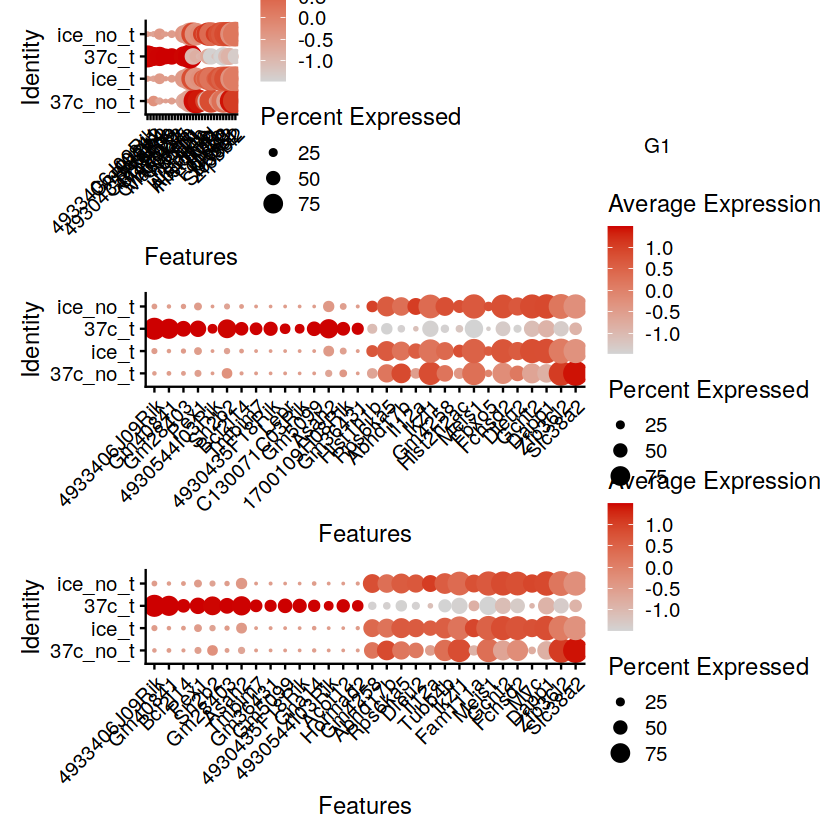

In [292]:
plot <- (p1 + grid::textGrob("G1")) / p2 / p3
plot

In [87]:
ggsave(plot, filename = "plots/1.svg", device = "svg", units = "in", width = 12, height = 12)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


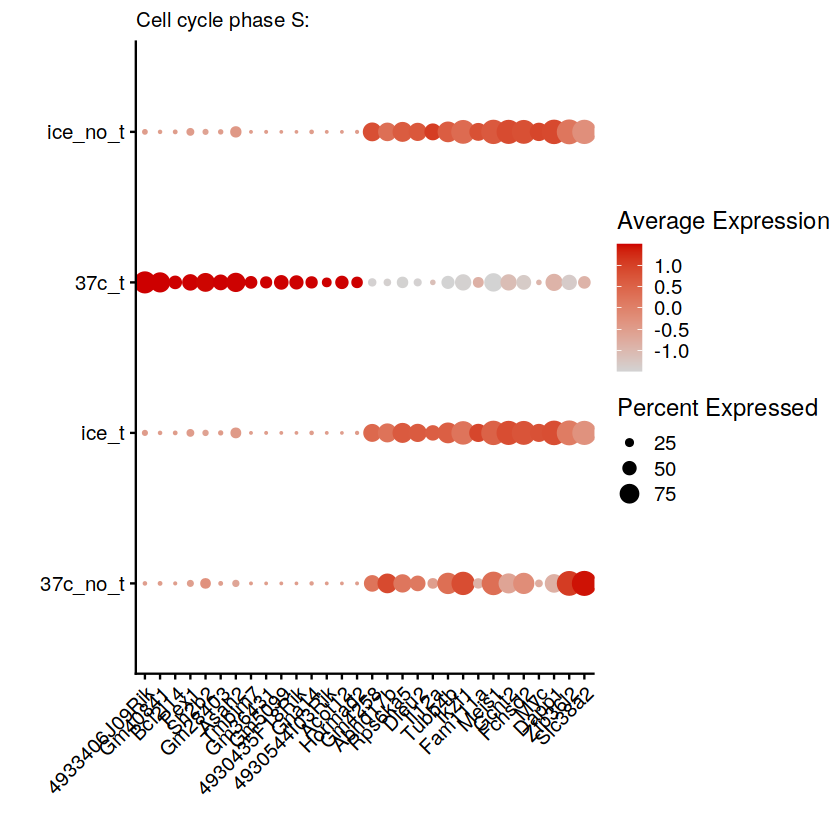

In [105]:
one_dot_plot <- \(comparison = "37c_t", n_genes = 15, phase = "S") {
    feats <- c(
        degs[[comparison]][[phase]] %>% head(., n = n_genes) %>% rownames,
        degs[[comparison]][[phase]] %>% tail(., n = n_genes) %>% rownames
    )
    plot <- DotPlot(sobj, features = feats, cols = cols_features) +
        theme(
            axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)
        ) +
        labs(
            # title = str_c("Comparison ", comparison, ":"),
            subtitle = str_c("Cell cycle phase ", phase, ":"),
            y = "",
            x = ""
            # y = "Condition",
            # x = "DEGs"
        )
    return(plot)
}
one_dot_plot()

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


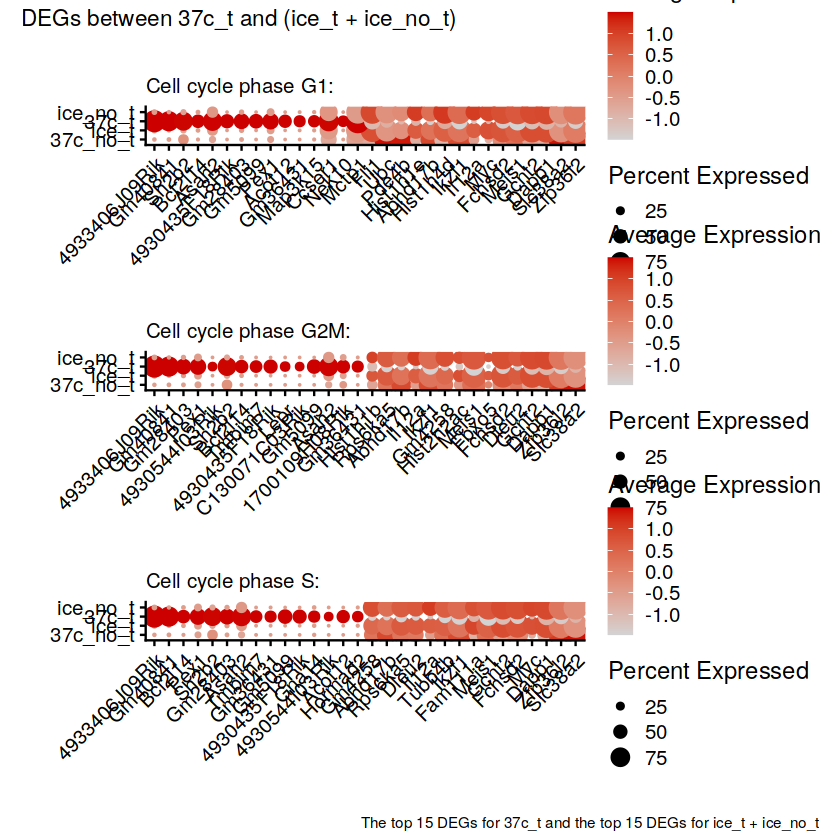

In [289]:
comp <- "37c_t"
n_genes <- 15
plot <- one_dot_plot(comparison = comp, phase = "G1") /
one_dot_plot(comparison = comp, phase = "G2M") /
one_dot_plot(comparison = comp, phase = "S") + plot_annotation(
  title = str_c(
    "DEGs between ",
    comparisons[[comp]][[1]],
    " and ",
    "(", str_flatten(comparisons[[comp]][[2]], " + "), ")"
  ),
  subtitle = "",
  caption = str_c(
    "The top ", n_genes, " DEGs for ", comp[[1]],
    " and the top ", n_genes, " DEGs for ", 
    str_flatten(comparisons[[comp]][[2]], " + ")
  )
)
plot

In [133]:
ggsave(plot, filename = "plots/1.svg", device = "svg", units = "in", width = 12, height = 12)

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


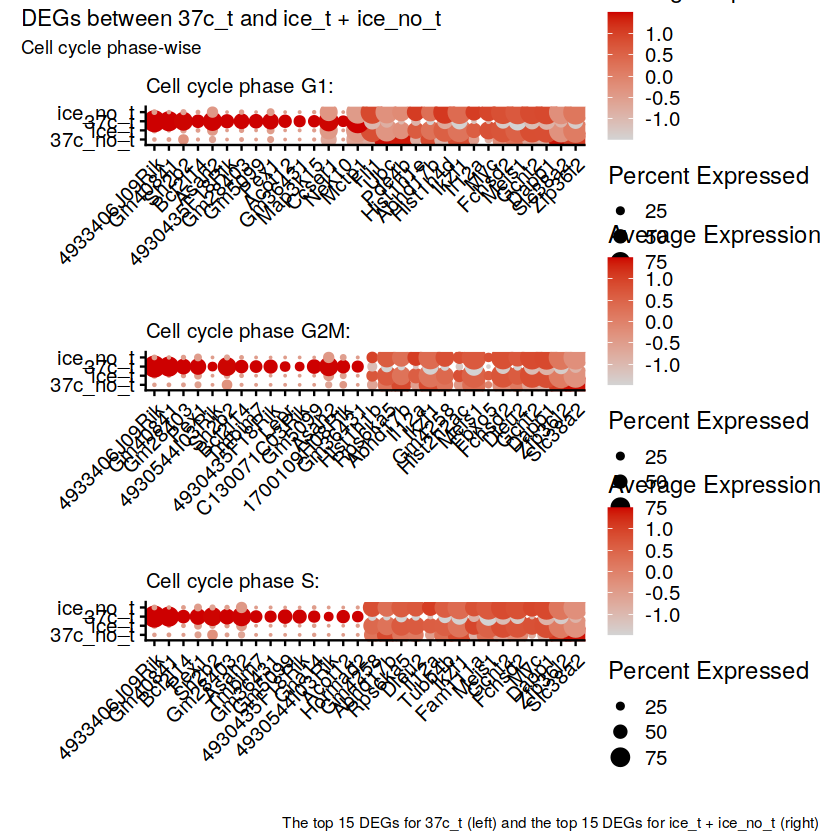

In [288]:
all_phases_dot_plot <- \(comparison = "37c_t", n_genes = 15) {
  plot <- one_dot_plot(comparison = comparison, phase = "G1") /
  one_dot_plot(comparison = comparison, phase = "G2M") /
  one_dot_plot(comparison = comparison, phase = "S") + plot_annotation(
    title = str_c(
      "DEGs between ",
      comparisons[[comparison]][[1]],
      " and ",
      str_flatten(comparisons[[comparison]][[2]], " + ")
    ),
    subtitle = "Cell cycle phase-wise",
    caption = str_c(
      "The top ", n_genes, " DEGs for ", comparisons[[comparison]][[1]],
      " (left) and the top ", n_genes, " DEGs for ", 
      str_flatten(comparisons[[comparison]][[2]], " + "),
      " (right)"
    )
  )
  plot %>% return
}
all_phases_dot_plot()

---

# Collated dot plots

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


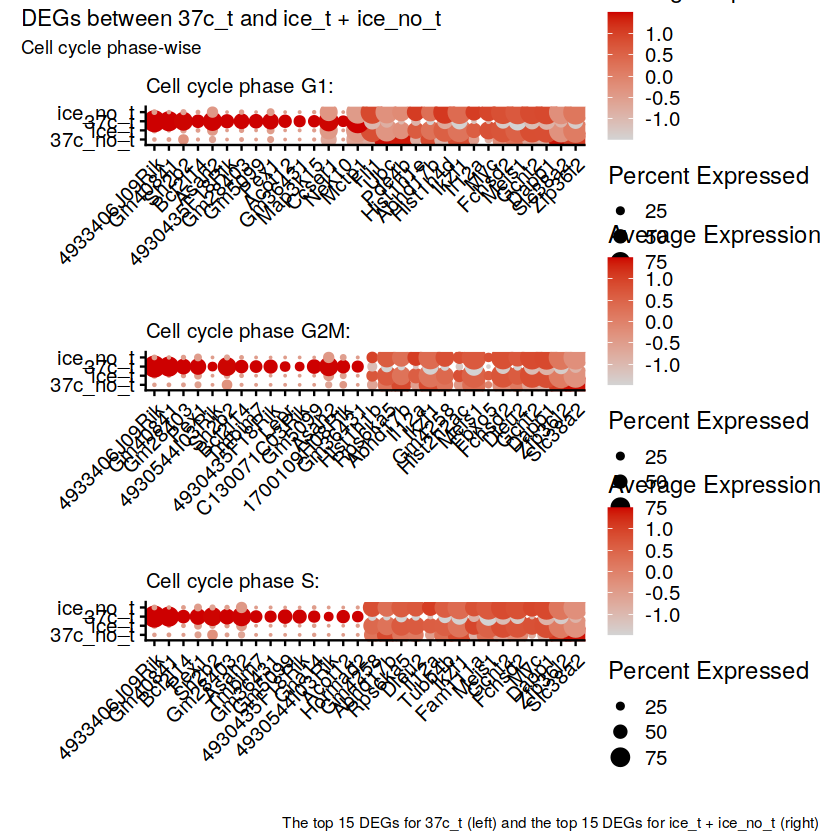

In [285]:
plot <- all_phases_dot_plot(comparison = "37c_t")
plot
ggsave(plot, filename = "plots/37c_t.svg", device = "svg", units = "in", width = 12, height = 12)

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


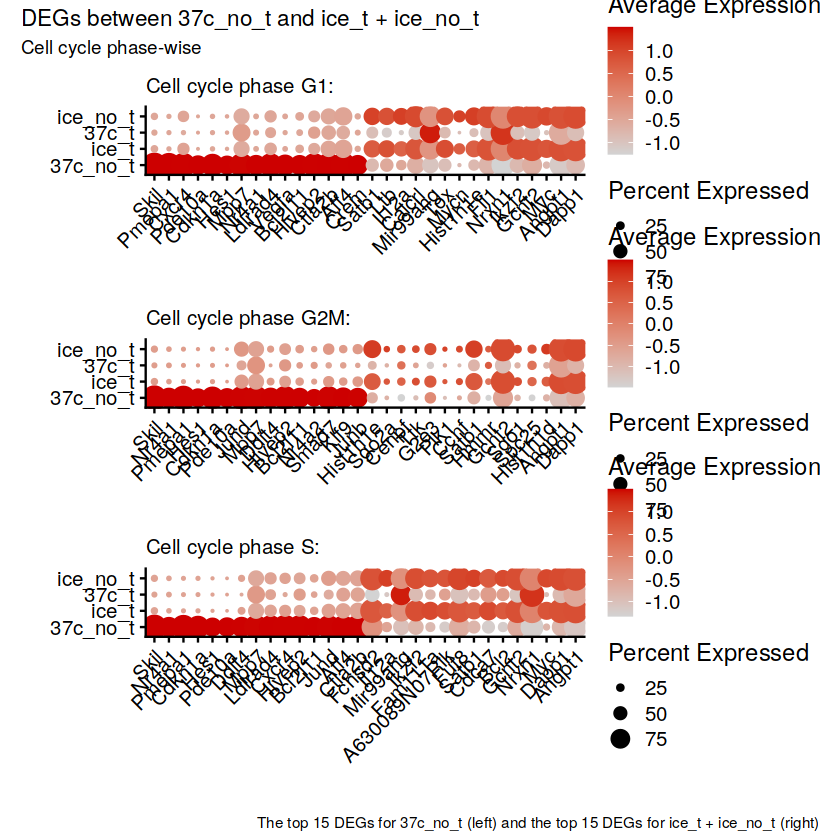

In [286]:
plot <- all_phases_dot_plot(comparison = "37c_no_t")
plot
ggsave(plot, filename = "plots/37c_no_t.svg", device = "svg", units = "in", width = 12, height = 12)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


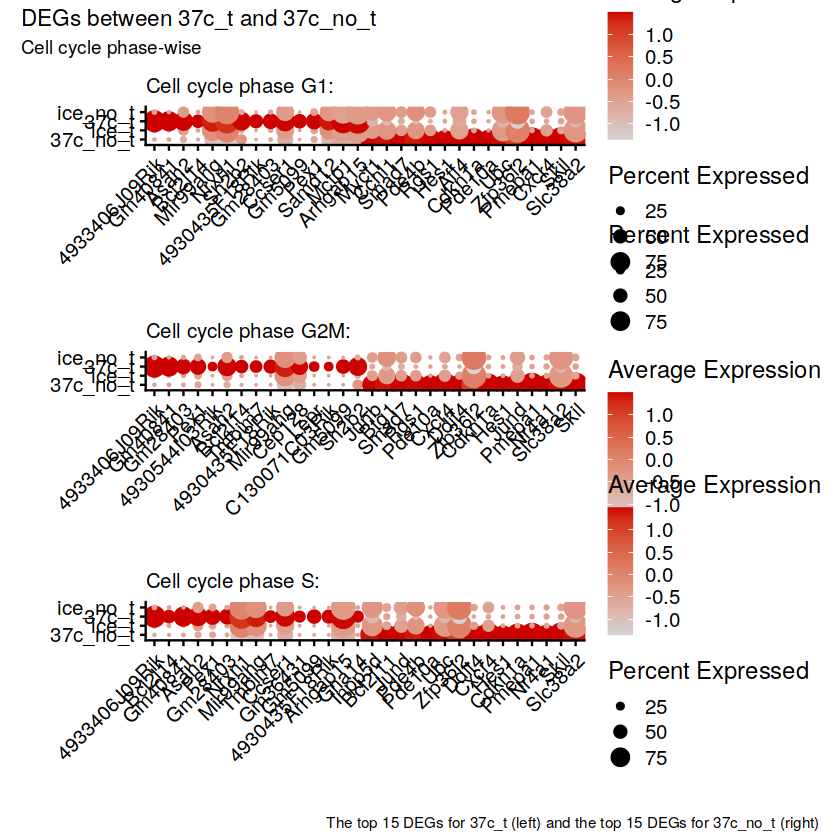

In [287]:
plot <- all_phases_dot_plot(comparison = "37c_t_vs_no_t")
plot
ggsave(plot, filename = "plots/37c_t_vs_no_t.svg", device = "svg", units = "in", width = 12, height = 12)

## Dot plots overlapping DEGs

Warning message:
“Scaling data with a low number of groups may produce misleading results”


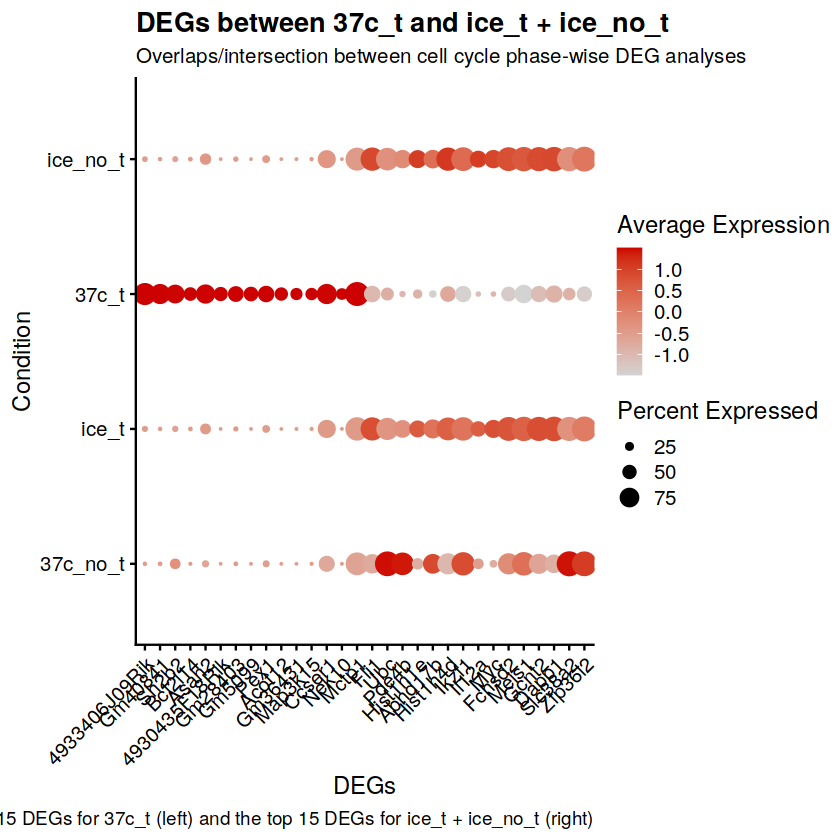

In [128]:
one_dot_plot_overlaps <- \(comparison = "37c_t", n_genes = 15) {
    feats <- c(
        overlaps[[comparison]] %>% head(., n = n_genes) %>% rownames,
        overlaps[[comparison]] %>% tail(., n = n_genes) %>% rownames
    )
    plot <- DotPlot(sobj, features = feats, cols = cols_features) +
        theme(
            axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)
        ) +
        labs(
            title = str_c(
                "DEGs between ",
                comparisons[[comparison]][[1]],
                " and ",
                str_flatten(comparisons[[comparison]][[2]], " + ")
            ),
            subtitle = str_c(
                "Overlaps/intersection between cell cycle phase-wise DEG analyses"
            ),
            caption = str_c(
                "The top ", n_genes, " DEGs for ", comparisons[[comparison]][[1]],
                " (left) and the top ", n_genes, " DEGs for ", 
                str_flatten(comparisons[[comparison]][[2]], " + "),
                " (right)"
            ),
            y = "Condition",
            x = "DEGs"
        )
    return(plot)
}
one_dot_plot_overlaps()

In [118]:
names(comparisons)

[1] "37c_t"         "37c_no_t"      "37c_t_vs_no_t"

Warning message:
“Scaling data with a low number of groups may produce misleading results”


Warning message:
“Scaling data with a low number of groups may produce misleading results”


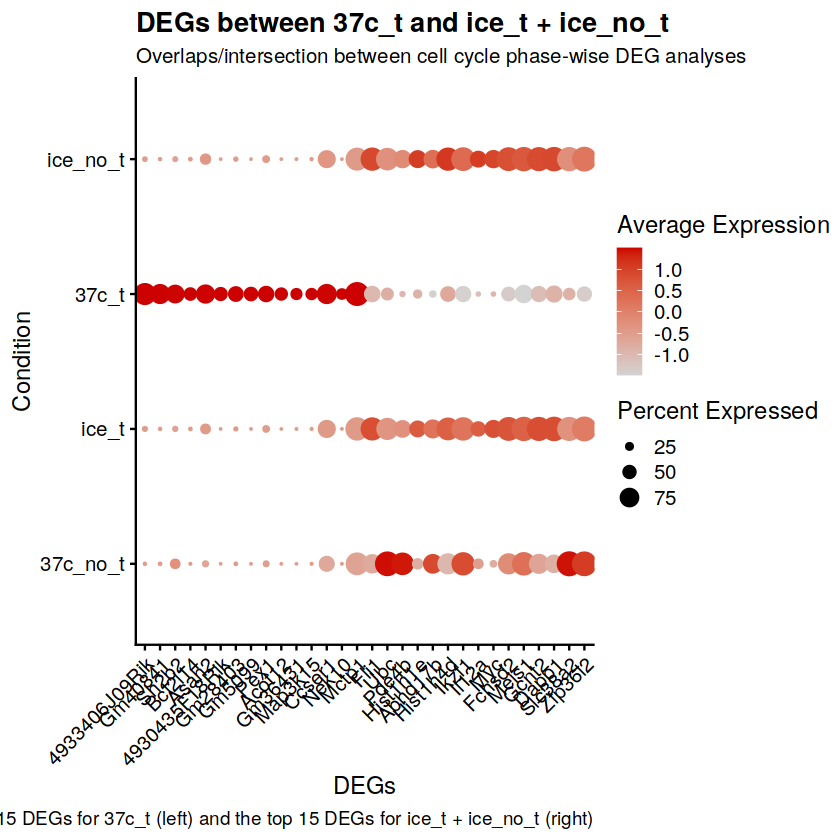

Warning message:
“Scaling data with a low number of groups may produce misleading results”


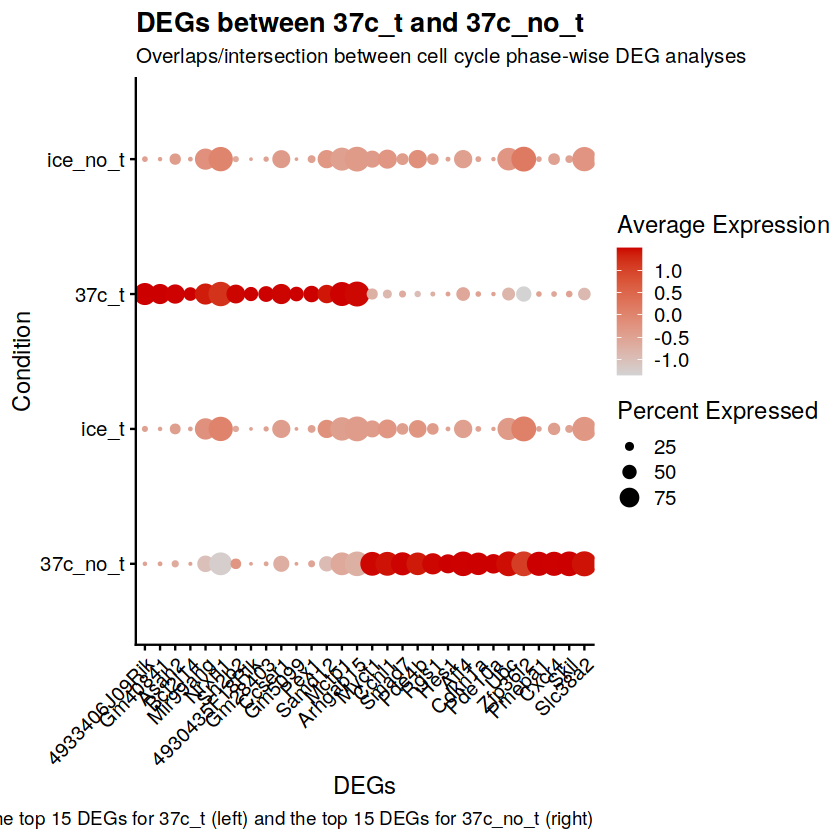

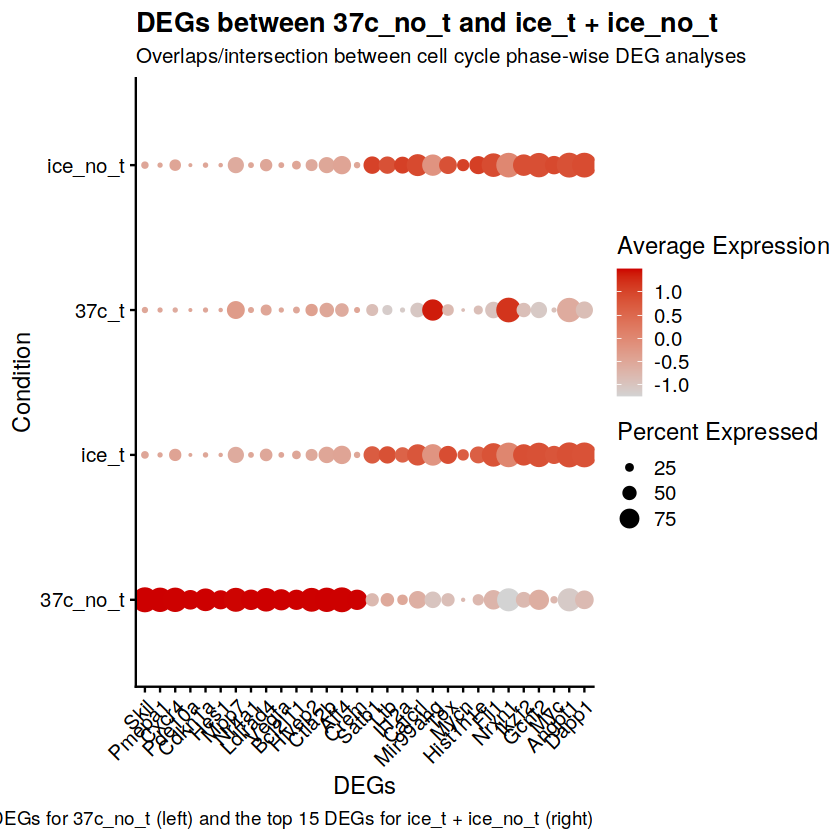

In [129]:
one_dot_plot_overlaps("37c_t")
one_dot_plot_overlaps("37c_t_vs_no_t")
one_dot_plot_overlaps("37c_no_t")

In [130]:
lapply(names(overlaps), FUN = \(comp) {
    ggsave(
        one_dot_plot_overlaps(comparison = comp),
        filename = str_c("plots/", "deg_overlap_", comp, ".svg"),
        device = "svg", units = "in", width = 12, height = 5
    )
})

Warning message:
“Scaling data with a low number of groups may produce misleading results”


Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


[[1]]
[1] "plots/deg_overlap_37c_t.svg"

[[2]]
[1] "plots/deg_overlap_37c_no_t.svg"

[[3]]
[1] "plots/deg_overlap_37c_t_vs_no_t.svg"

---

# QC plots

In [230]:
sobj[[]] %>% colnames

[1] "orig.ident"        "nCount_RNA"        "nFeature_RNA"     
 [4] "nCount_ADT"        "nFeature_ADT"      "nCount_HTO"       
 [7] "nFeature_HTO"      "percent.mt"        "hto"              
[10] "sample"            "sample_longname"   "buffer_treatment" 
[13] "incubation_method" "S.Score"           "G2M.Score"        
[16] "Phase"             "old.ident"         "RNA_snn_res.0.8"  
[19] "seurat_clusters"   "stress_signature1" "is_stressed"

In [254]:
feats_of_interest <- list(
  "nCount_RNA", "nFeature_RNA", "nCount_ADT", "nCount_HTO", "percent.mt", "stress_signature1"
)
feats_of_interest

[[1]]
[1] "nCount_RNA"

[[2]]
[1] "nFeature_RNA"

[[3]]
[1] "nCount_ADT"

[[4]]
[1] "nCount_HTO"

[[5]]
[1] "percent.mt"

[[6]]
[1] "stress_signature1"

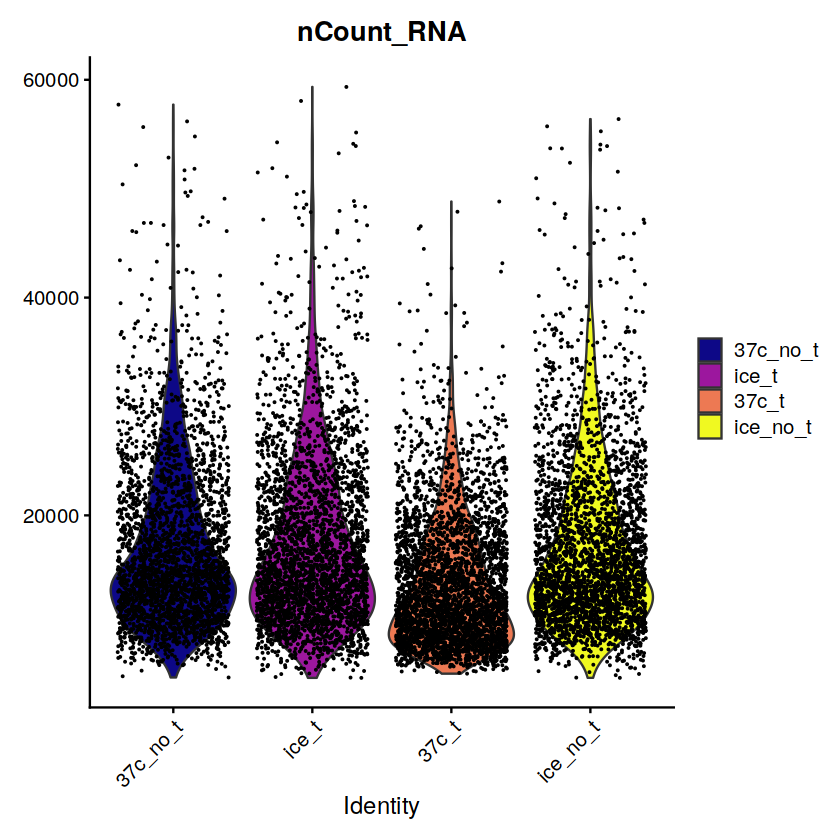

In [253]:
qc_plot <- \(feat = "nCount_RNA") {
    VlnPlot(sobj, features = feat) +
        scale_fill_viridis(discrete = T, option = "plasma")
}
qc_plot()

In [256]:
plots <- lapply(feats_of_interest, qc_plot)

In [258]:
names(plots) <- feats_of_interest

In [263]:
lapply(feats_of_interest, FUN = \(feat) ggsave(plots[[feat]],
    filename = str_c("plots/qc_", feat, ".svg"),
    device = "svg",
    units = "in",
    width = 6,
    height = 6)
)

[[1]]
[1] "plots/qc_nCount_RNA.svg"

[[2]]
[1] "plots/qc_nFeature_RNA.svg"

[[3]]
[1] "plots/qc_nCount_ADT.svg"

[[4]]
[1] "plots/qc_nCount_HTO.svg"

[[5]]
[1] "plots/qc_percent.mt.svg"

[[6]]
[1] "plots/qc_stress_signature1.svg"

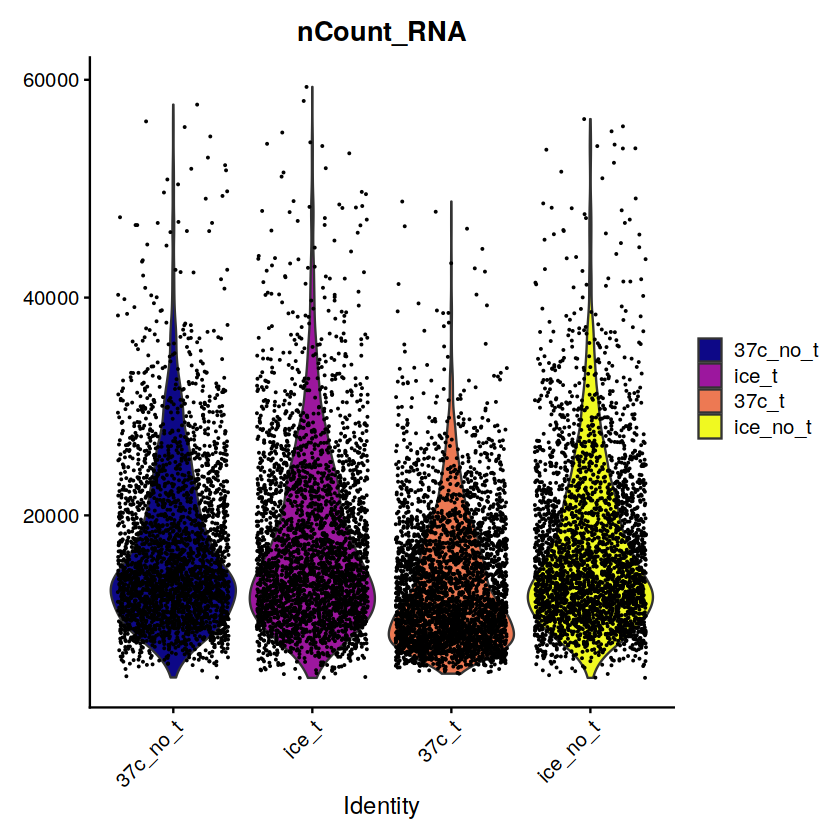

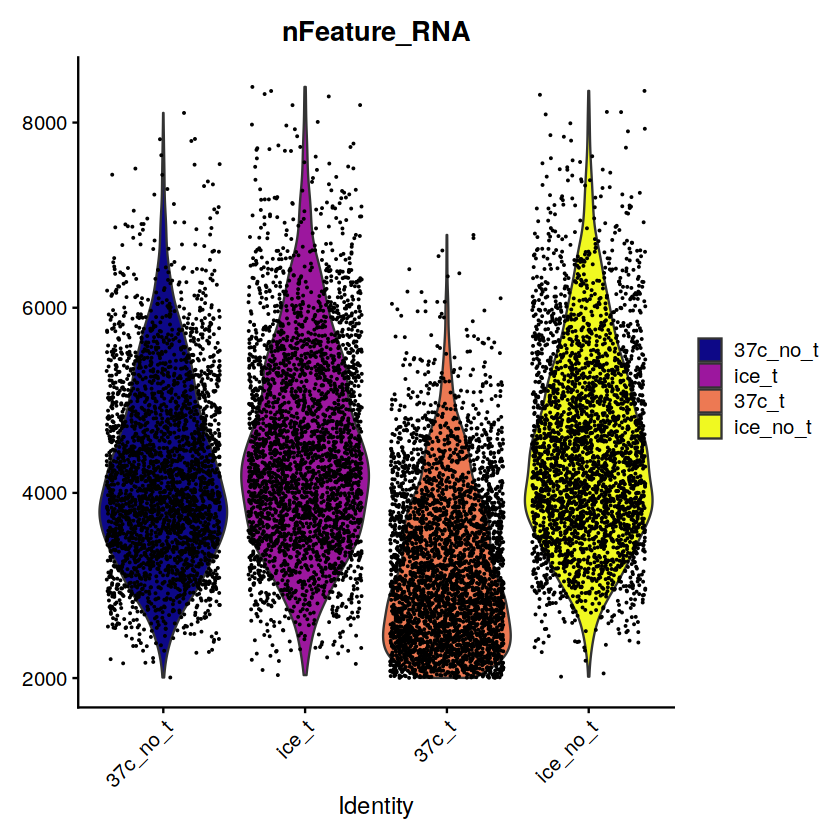

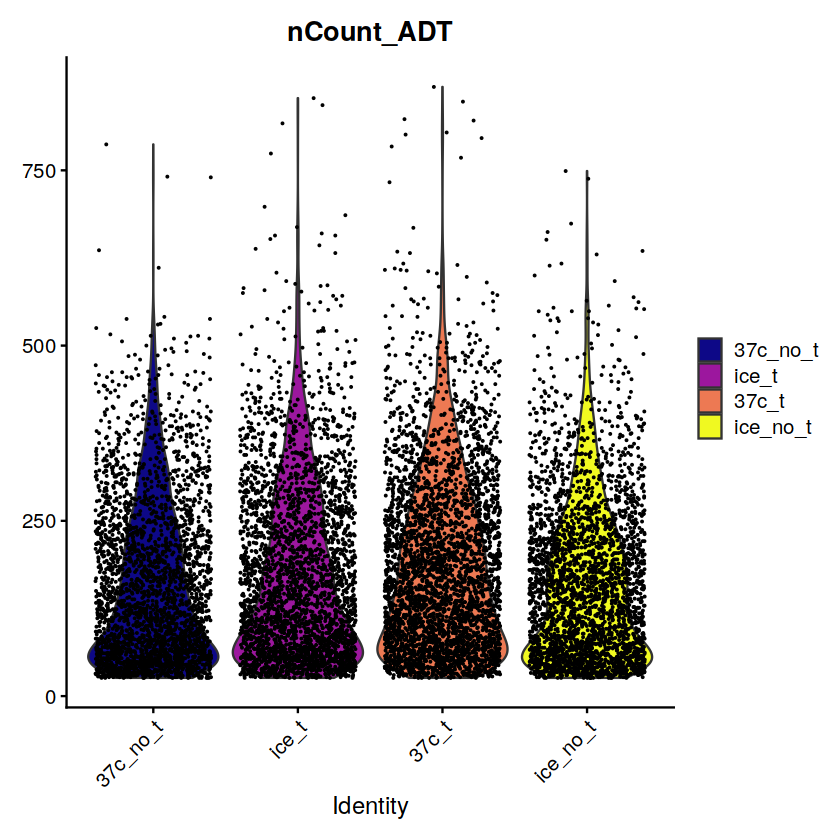

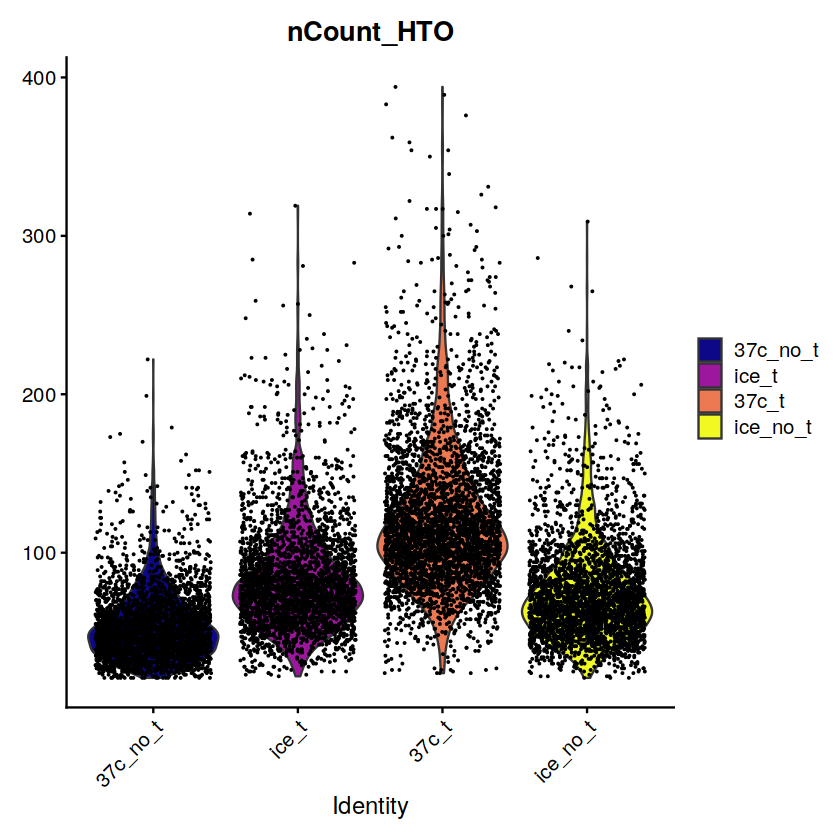

$nCount_RNA

$nFeature_RNA

$nCount_ADT

$nCount_HTO

$percent.mt

$stress_signature1


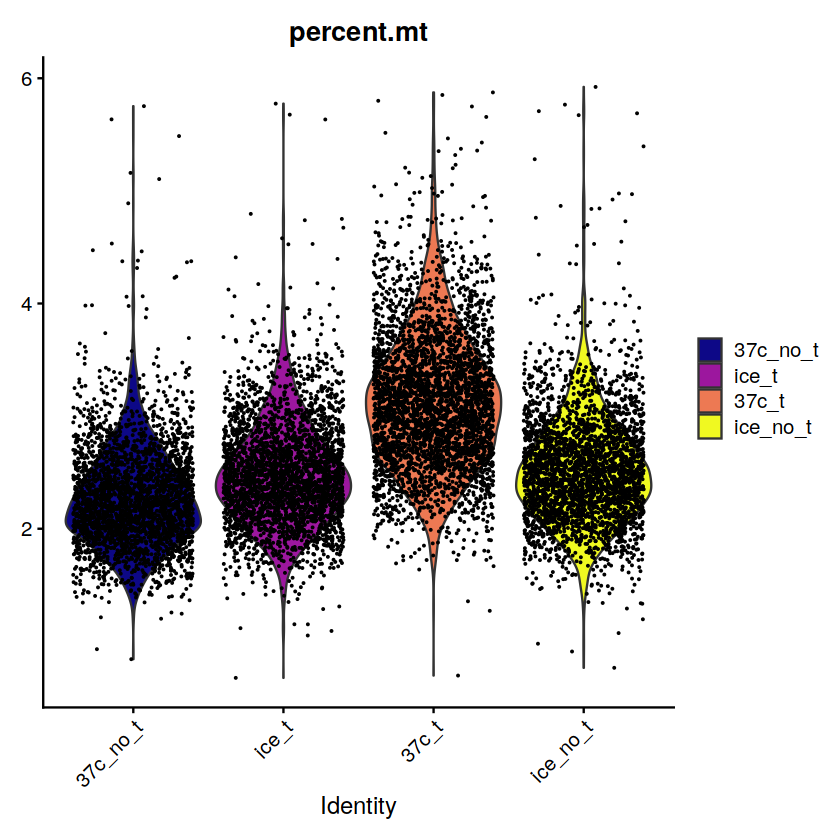

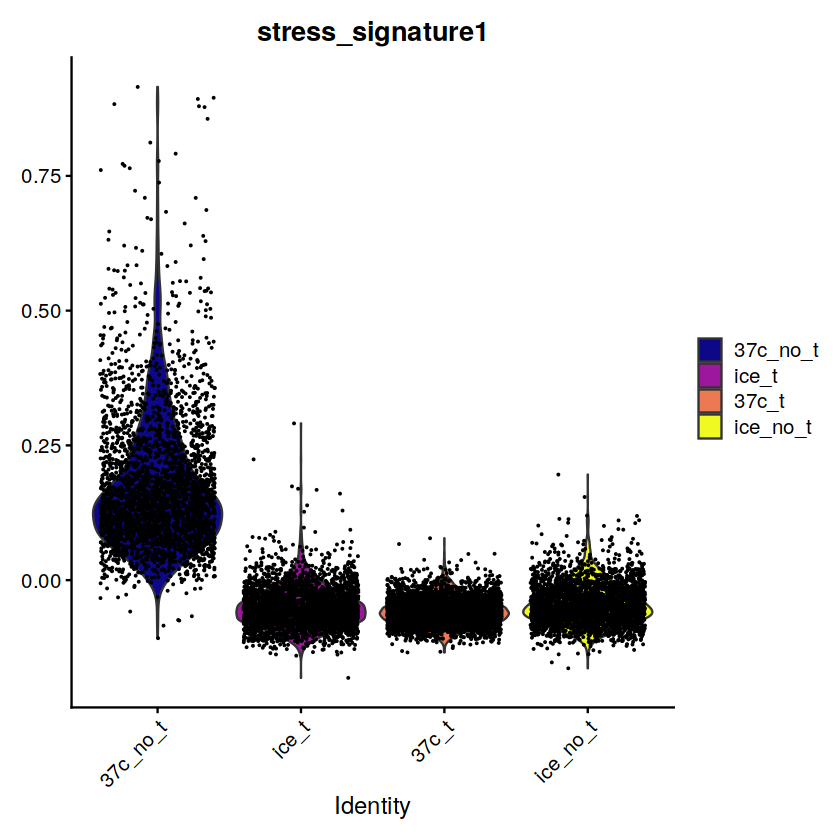

In [264]:
plots

---

# Signatures

In [325]:
signature_file <- "../data/raw/Genesets.gmx.txt"

In [326]:
dirname(signature_file) %>% dir

[1] "Annas - Stress GEX analysis" "cellranger-GRCh38-mm10"     
[3] "cellranger-mm10"             "Genesets.gmx.txt"           
[5] "HTO-fastqs"                  "md5sum.txt"                 
[7] "RNA-fastqs"                  "stress_signature.tsv"

In [330]:
sigs_dirty <- read.delim(signature_file)
sigs_dirty %>% head

Stress.induced.in.HSCs Aged.HSC.genes_Flohr.Svendsen.et.al
1 na                     na                                 
2 Egr2                   Ntf3                               
3 Atf3                   Mab21l2                            
4 Klf2                   Sbspon                             
5 Nr4a1                  Osmr                               
6 Ptgs2                  Cntn1                              
  Young.HSC.genes_Flohr.Svendsen.et.al Cell.cycle.in.HSCs
1 na                                   na                
2 Lsp1                                 Rpa2              
3 Slc28a2                              Hspa8             
4 Rfc2                                 Dtymk             
5 Ctss                                 Sqle              
6 Mlec                                 Mcm5

In [357]:
sigs <- list()

In [358]:
sigs[["cc"]] <- sigs_dirty[[colnames(sigs_dirty)[
    str_detect("cycle", string = colnames(sigs_dirty))]
]]
sigs[["young"]] <- sigs_dirty[[colnames(sigs_dirty)[
    str_detect("Young", string = colnames(sigs_dirty))]
]]
sigs[["aged"]] <- sigs_dirty[[colnames(sigs_dirty)[
    str_detect("Aged", string = colnames(sigs_dirty))]
]]
sigs[["stress"]] <- sigs_dirty[[colnames(sigs_dirty)[
    str_detect("Stress", string = colnames(sigs_dirty))]
]]
sigs

$cc
  [1] "na"       "Rpa2"     "Hspa8"    "Dtymk"    "Sqle"     "Mcm5"    
  [7] "Stmn1"    "Dmd"      "Prmt5"    "Bcl3"     "Nasp"     "Ss18"    
 [13] "Mcm3"     "Orc6"     "Sfpq"     "Mybl2"    "Orc5"     "Wrn"     
 [19] "Pttg1"    "Ythdc1"   "Smad3"    "Mapk14"   "Amd1"     "Map3k20" 
 [25] "Bub3"     "Hnrnpd"   "Kpnb1"    "Ube2s"    "Cks1b"    "Srsf1"   
 [31] "E2f4"     "Ddx39a"   "Traip"    "Lbr"      "H2az2"    "Polq"    
 [37] "Dkc1"     "Arid4a"   "Rps6ka5"  "Cdc7"     "Slc7a1"   "Pola2"   
 [43] "Prpf4b"   "H2az1"    "Abl1"     "Pafah1b1" "Lmnb1"    "Jpt1"    
 [49] "Gspt1"    "Odf2"     "Foxn3"    "Troap"    "Hus1"     "Ctcf"    
 [55] "Numa1"    "Cdc27"    "Top1"     "Prim2"    "Pml"      "Pds5b"   
 [61] "Kif5b"    "Nup50"    "Xpo1"     "Notch2"   "Atrx"     "Nsd2"    
 [67] "Rad21"    "Tle3"     "Ezh2"     "Nup98"    "Stag1"    "Tent4a"  
 [73] "Cdc25a"   "Smc1a"    "Rbl1"     "Lig3"     "Tmpo"     "E2f3"    
 [79] "Slc38a1"  "Rad54l"   "Suv39h1"  "Mtf2"     "Egf"      "Pura"    
 [85] "Rasal2"   "Mad2l1"   "Pole"     "Ccnt1"    "Smarcc1"  "Cdkn2c"  
 [91] "Cdc25b"   "Brca2"    "Exo1"     "Hira"     "Dbf4"     "Cks2"    
 [97] "Cdc45"    "Smc2"     "Smc4"     "Pbk"      "H2ax"     "Cdc20"   
[103] "Plk4"     "Ndc80"    "Tacc3"    "Cenpa"    "Kif22"    "Incenp"  
[109] "Stil"     "Kif23"    "Knl1"     "Racgap1"  "Top2a"    "Fbxo5"   
[115] "Cdk1"     "Ccnf"     "Ccnb2"    "Ttk"      "Aurka"    "Kif20b"  
[121] "Cdkn3"    "Mki67"    "Plk1"     "Ccna2"    "Tpx2"     "Aurkb"   
[127] "Birc5"    "Nusap1"   "Kif4"     "Hmmr"     "Nek2"     "Espl1"   
[133] "Bub1"     "Cenpe"    "Kif11"    "Prc1"     "Kif2c"    "Cenpf"   
[139] "Ube2c"    ""         ""         ""         ""         ""        
[145] ""         ""         ""         ""         ""         ""        
[151] ""         ""         ""         ""         ""         ""        
[157] ""         ""         ""         ""         ""         ""        
[163] ""         ""         ""         ""         ""         ""        
[169] ""         ""         ""         ""         ""         ""        
[175] ""         ""         ""         ""         ""         ""        
[181] ""         ""        

$young
  [1] "na"       "Lsp1"     "Slc28a2"  "Rfc2"     "Ctss"     "Mlec"    
  [7] "Il15"     "Anxa2"    "Syk"      "Ect2"     "Mcm5"     "Antxr2"  
 [13] "Mamdc2"   "Cd34"     "Arhgap30" "Lst1"     "Mgst1"    "Col4a2"  
 [19] "Tm6sf1"   "Ebi3"     "Dnmt3b"   "Cd37"     "Plxdc2"   "Rnase6"  
 [25] "Flt3"     "Sell"     "Rassf4"   "Csf2rb"   "Mcm7"     "Plac8"   
 [31] "Cd86"     "Hnf4a"    "Socs2"    "Il12rb2"  "Satb1"    "Nrk"     
 [37] "Camk1d"   "Lgals1"   "Anxa6"    "Mmp2"     ""         ""        
 [43] ""         ""         ""         ""         ""         ""        
 [49] ""         ""         ""         ""         ""         ""        
 [55] ""         ""         ""         ""         ""         ""        
 [61] ""         ""         ""         ""         ""         ""        
 [67] ""         ""         ""         ""         ""         ""        
 [73] ""         ""         ""         ""         ""         ""        
 [79] ""         ""         ""         ""         ""         ""        
 [85] ""         ""         ""         ""         ""         ""        
 [91] ""         ""         ""         ""         ""         ""        
 [97] ""         ""         ""         ""         ""         ""        
[103] ""         ""         ""         ""         ""         ""        
[109] ""         ""         ""         ""         ""         ""        
[115] ""         ""         ""         ""         ""         ""        
[121] ""         ""         ""         ""         ""         ""        
[127] ""         ""         ""         ""         ""         ""        
[133] ""         ""         ""         ""         ""         ""        
[139] ""         ""         ""         ""         ""         ""        
[145] ""         ""         ""         ""         ""         ""        


In [359]:
saved_names <- names(sigs)
sigs <- lapply(sigs, FUN = \(s) s[s %>% str_length > 0 & s != "na"])
# sigs <- lapply(names(sigs), FUN = \(s) sigs[[s]][sigs[[s]] %>% str_length > 0 & sigs[[s]] != "na"])
# names(sigs) <- saved_names
sigs

$cc
  [1] "Rpa2"     "Hspa8"    "Dtymk"    "Sqle"     "Mcm5"     "Stmn1"   
  [7] "Dmd"      "Prmt5"    "Bcl3"     "Nasp"     "Ss18"     "Mcm3"    
 [13] "Orc6"     "Sfpq"     "Mybl2"    "Orc5"     "Wrn"      "Pttg1"   
 [19] "Ythdc1"   "Smad3"    "Mapk14"   "Amd1"     "Map3k20"  "Bub3"    
 [25] "Hnrnpd"   "Kpnb1"    "Ube2s"    "Cks1b"    "Srsf1"    "E2f4"    
 [31] "Ddx39a"   "Traip"    "Lbr"      "H2az2"    "Polq"     "Dkc1"    
 [37] "Arid4a"   "Rps6ka5"  "Cdc7"     "Slc7a1"   "Pola2"    "Prpf4b"  
 [43] "H2az1"    "Abl1"     "Pafah1b1" "Lmnb1"    "Jpt1"     "Gspt1"   
 [49] "Odf2"     "Foxn3"    "Troap"    "Hus1"     "Ctcf"     "Numa1"   
 [55] "Cdc27"    "Top1"     "Prim2"    "Pml"      "Pds5b"    "Kif5b"   
 [61] "Nup50"    "Xpo1"     "Notch2"   "Atrx"     "Nsd2"     "Rad21"   
 [67] "Tle3"     "Ezh2"     "Nup98"    "Stag1"    "Tent4a"   "Cdc25a"  
 [73] "Smc1a"    "Rbl1"     "Lig3"     "Tmpo"     "E2f3"     "Slc38a1" 
 [79] "Rad54l"   "Suv39h1"  "Mtf2"     "Egf"      "Pura"     "Rasal2"  
 [85] "Mad2l1"   "Pole"     "Ccnt1"    "Smarcc1"  "Cdkn2c"   "Cdc25b"  
 [91] "Brca2"    "Exo1"     "Hira"     "Dbf4"     "Cks2"     "Cdc45"   
 [97] "Smc2"     "Smc4"     "Pbk"      "H2ax"     "Cdc20"    "Plk4"    
[103] "Ndc80"    "Tacc3"    "Cenpa"    "Kif22"    "Incenp"   "Stil"    
[109] "Kif23"    "Knl1"     "Racgap1"  "Top2a"    "Fbxo5"    "Cdk1"    
[115] "Ccnf"     "Ccnb2"    "Ttk"      "Aurka"    "Kif20b"   "Cdkn3"   
[121] "Mki67"    "Plk1"     "Ccna2"    "Tpx2"     "Aurkb"    "Birc5"   
[127] "Nusap1"   "Kif4"     "Hmmr"     "Nek2"     "Espl1"    "Bub1"    
[133] "Cenpe"    "Kif11"    "Prc1"     "Kif2c"    "Cenpf"    "Ube2c"   

$young
 [1] "Lsp1"     "Slc28a2"  "Rfc2"     "Ctss"     "Mlec"     "Il15"    
 [7] "Anxa2"    "Syk"      "Ect2"     "Mcm5"     "Antxr2"   "Mamdc2"  
[13] "Cd34"     "Arhgap30" "Lst1"     "Mgst1"    "Col4a2"   "Tm6sf1"  
[19] "Ebi3"     "Dnmt3b"   "Cd37"     "Plxdc2"   "Rnase6"   "Flt3"    
[25] "Sell"     "Rassf4"   "Csf2rb"   "Mcm7"     "Plac8"    "Cd86"    
[31] "Hnf4a"    "Socs2"    "Il12rb2"  "Satb1"    "Nrk"      "Camk1d"  
[37] "Lgals1"   "Anxa6"    "Mmp2"    

$aged
  [1] "Ntf3"      "Mab21l2"   "Sbspon"    "Osmr"      "Cntn1"     "Gabra4"   
  [7] "Gipc2"     "Clu"       "Rbpjl"     "Zg16"      "Selp"      "Tdrd9"    
 [13] "Mt2"       "Lrrn1"     "Clca3a1"   "Plscr2"    "Tc2n"      "Matn4"    
 [19] "Fap"       "Muc1"      "Ramp2"     "Tmem215"   "Trpc1"     "Chrna7"   
 [25] "Rgn"       "Rorb"      "Tm4sf1"    "Wwtr1"     "Gpr183"    "Zswim5"   
 [31] "C4b"       "Nupr1"     "Gstm2"     "Bmpr1a"    "Tmem47"    "Gda"      
 [37] "Sult1a1"   "Tmem56"    "Mt1"       "Aspa"      "Cyb561"    "Neo1"     
 [43] "Adgrg2"    "Pclo"      "Gm10419"   "Klrb1c"    "Jam2"      "Maf"      
 [49] "Dsg2"      "Perp"      "Lpl"       "Pgr"       "Ddr1"      "Clec1a"   
 [55] "Dnm3"      "B3galt1"   "Meis2"     "Ptprk"     "Ehd3"      "Aldh1a1"  
 [61] "Cavin2"    "Phf11d"    "Abat"      "Runx1t1"   "Amotl2"    "Acpp"     
 [67] "Cd200r4"   "Kdr"       "Alcam"     "Asb4"      "Cd38"      "Klhl4"    
 [73] "Enpp5"     "Il1rapl2"  "Gadd45g"   "Sfrp1"     "Zfp36"     "Nrg4"     
 [79] "Cpne8"     "Fhdc1"     "Cysltr2"   "Plcl1"     "Abca4"     "Clec1b"   
 [85] "Vldlr"     "Pcdhb16"   "Hpgds"     "Abcb1a"    "Vwf"       "Ghr"      
 [91] "Slc6a15"   "Mmp14"     "Klrb1b"    "Id2"       "Zfp334"    "Gem"      
 [97] "Ocln"      "Plek"      "Ptger4"    "Thbd"      "Ldhd"      "Itgb3"    
[103] "S100a6"    "Dhrs3"     "Rhoj"      "Rdh10"     "Fhl1"      "Oxr1"     
[109] "Rorc"      "Rab34"     "Cyyr1"     "Myo1e"     "Stxbp4"    "Dennd5b"  
[115] "Ampd3"     "Stom"      "Lsr"       "Cyp26b1"   "Plscr1"    "Casp12"   
[121] "Mllt3"     "Pbx3"      "Tacstd2"   "Bcl6"      "Pdgfd"     "Egr1"     
[127] "Cytip"     "Ndrg1"     "Cd9"       "Tox"       "Efna1"     "Vmp1"     
[133] "Trim47"    "Tgm2"      "Arhgap29"  "Serpinb8"  "Prcp"      "Pros1"    
[139] "Prtn3"     "Nckap1"    "Phactr1"   "Tbc1d8"    "Arhgef28"  "

In [371]:
lapply(sigs, FUN = \(s) s %in% rownames(sobj) %>% table)
# lapply(sigs, FUN = \(s) lapply(s,
#     FUN = \(gene) str_detect(pattern = gene, string = rownames(sobj)) %>% sum
#     ) %>% table
# )

$cc
.
FALSE  TRUE 
    4   134 

$young
.
TRUE 
  39 

$aged
.
TRUE 
 181 

$stress
.
TRUE 
  78 


In [376]:
s <- "cc"
new <- AddModuleScore(sobj, features = sigs, name = names(sigs))
new

Warning message:
“The following features are not present in the object: Ddx39a, H2az2, H2az1, H2ax, not searching for symbol synonyms”


An object of class Seurat 
32293 features across 12566 samples within 3 assays 
Active assay: RNA (32285 features, 2000 variable features)
 2 other assays present: ADT, HTO
 2 dimensional reductions calculated: pca, umap

In [377]:
new[[]] %>% head

orig.ident     nCount_RNA nFeature_RNA nCount_ADT
AAACCCAAGAGACAAG-1 DB_AKC_citeseq 11976      3437         128       
AAACCCAAGAGTGAAG-1 DB_AKC_citeseq 21028      5475          54       
AAACCCAAGCGAAACC-1 DB_AKC_citeseq 10688      2813          56       
AAACCCAAGGTAAAGG-1 DB_AKC_citeseq 10627      3677          68       
AAACCCAAGGTCTACT-1 DB_AKC_citeseq 16865      3915         106       
AAACCCAAGTCGGCCT-1 DB_AKC_citeseq 13939      4192          60       
                   nFeature_ADT nCount_HTO nFeature_HTO percent.mt hto 
AAACCCAAGAGACAAG-1 4             32        3            2.104208   HTO2
AAACCCAAGAGTGAAG-1 4            108        4            2.425338   HTO3
AAACCCAAGCGAAACC-1 3             87        2            4.519087   HTO4
AAACCCAAGGTAAAGG-1 4             79        4            2.888868   HTO1
AAACCCAAGGTCTACT-1 4             99        2            2.514082   HTO4
AAACCCAAGTCGGCCT-1 3             75        2            3.285745   HTO3
                   sample   ⋯ Phase old.ident RNA_snn_res.0.8 seurat_clusters
AAACCCAAGAGACAAG-1 37c_no_t ⋯ G1    HTO2      0               0              
AAACCCAAGAGTGAAG-1 ice_t    ⋯ S     HTO3      1               1              
AAACCCAAGCGAAACC-1 37c_t    ⋯ G1    HTO4      5               5              
AAACCCAAGGTAAAGG-1 ice_no_t ⋯ G1    HTO1      2               2              
AAACCCAAGGTCTACT-1 37c_t    ⋯ S     HTO4      7               7              
AAACCCAAGTCGGCCT-1 ice_t    ⋯ G1    HTO3      2               2              
                   stress_signature1 is_stressed  cc1         young2      
AAACCCAAGAGACAAG-1  0.19599848       stressed      0.03920330 -0.149312883
AAACCCAAGAGTGAAG-1 -0.10710847       not_stressed  0.10166306 -0.142437271
AAACCCAAGCGAAACC-1 -0.04234327       not_stressed -0.06231414  0.005144908
AAACCCAAGGTAAAGG-1 -0.04919840       not_stressed -0.04869483 -0.107309223
AAACCCAAGGTCTACT-1 -0.08366769       not_stressed  0.15123558 -0.007321353
AAACCCAAGTCGGCCT-1 -0.09381362       not_stressed -0.09269975 -0.104607233
                   aged3       stress4    
AAACCCAAGAGACAAG-1 -0.01416662  0.19209645
AAACCCAAGAGTGAAG-1 -0.04962019 -0.10621570
AAACCCAAGCGAAACC-1 -0.05448123 -0.04383476
AAACCCAAGGTAAAGG-1 -0.04362710 -0.05414716
AAACCCAAGGTCTACT-1 -0.07141288 -0.08157760
AAACCCAAGTCGGCCT-1  0.03109269 -0.09134155

In [381]:
cols <- c("gray", "lightcoral", "red")


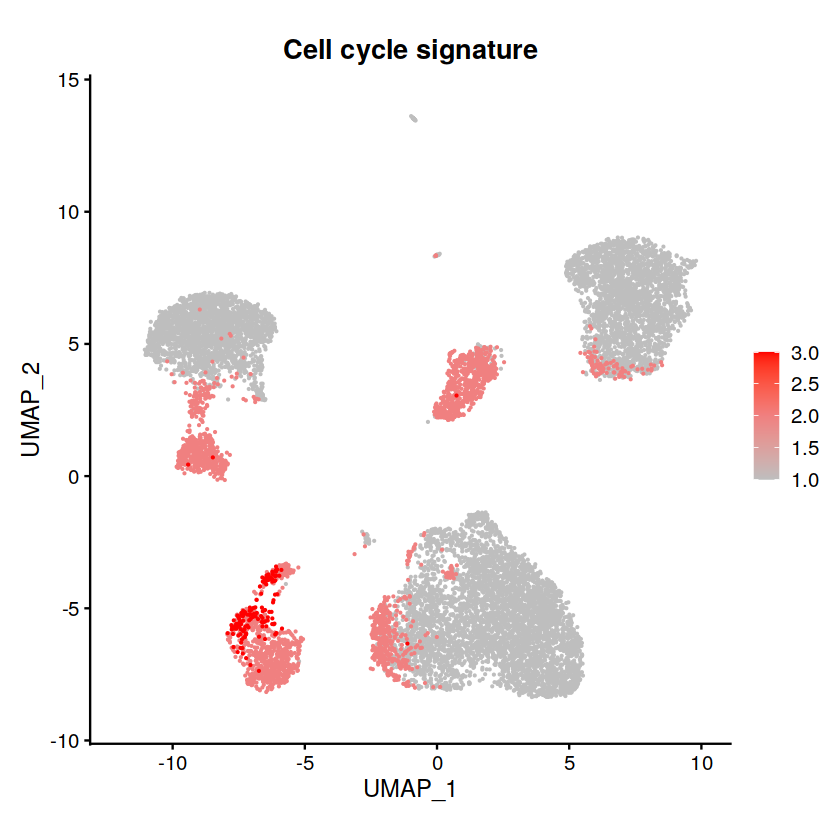

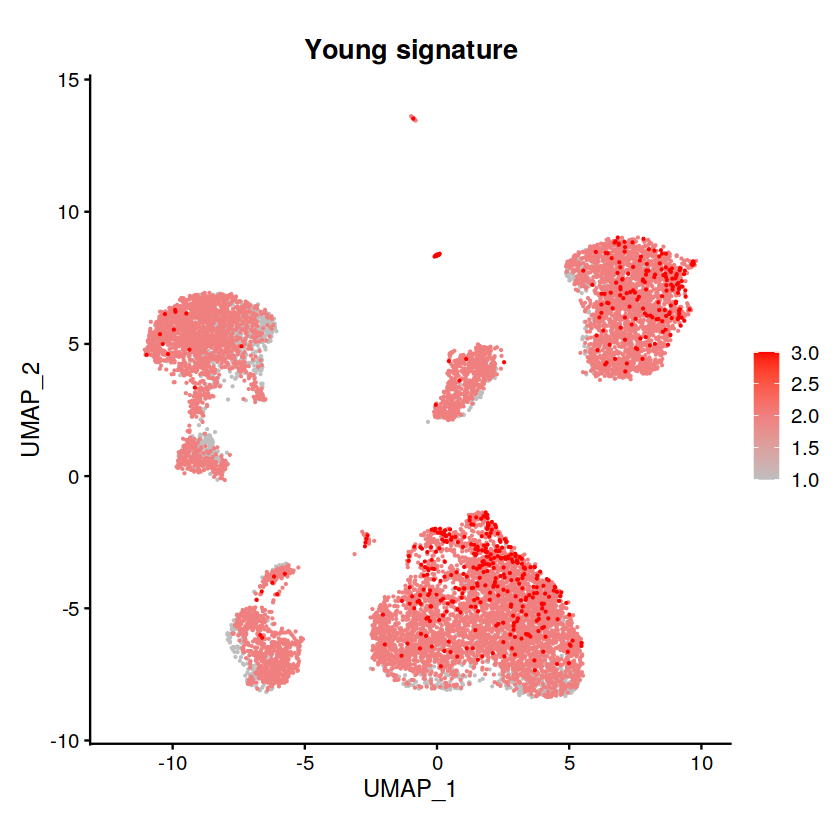

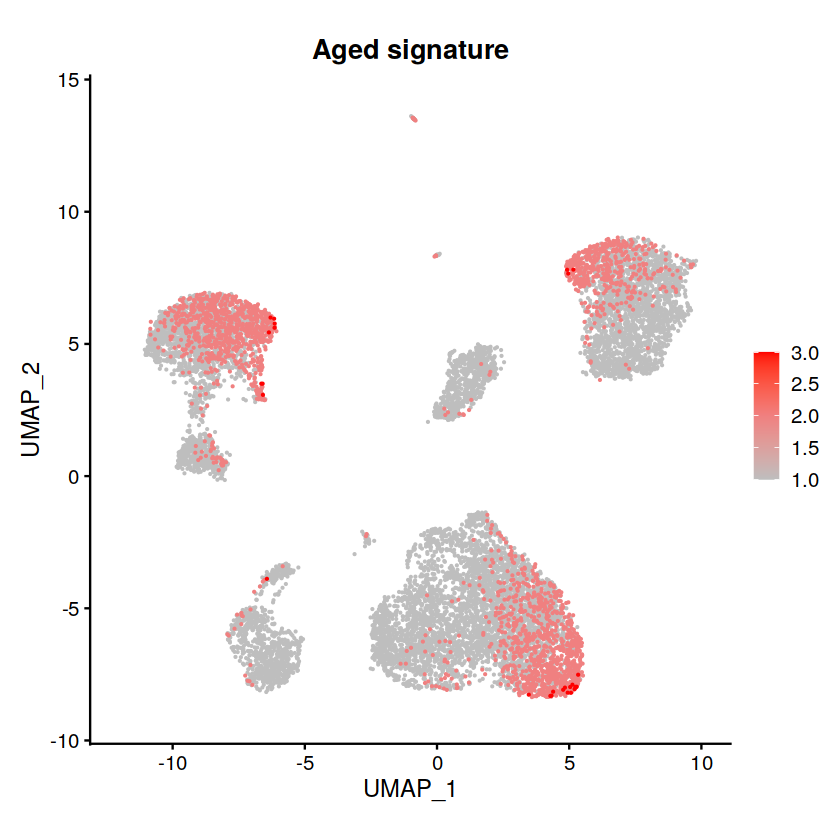

In [386]:
cc <- FeaturePlot(new, features = "cc1", coord.fixed = T, order = T, cols = cols) +
    ggtitle("Cell cycle signature")
young <- FeaturePlot(new, features = "young2", coord.fixed = T, order = T, cols = cols) +
    ggtitle("Young signature")
aged <- FeaturePlot(new, features = "aged3", coord.fixed = T, order = T, cols = cols) +
    ggtitle("Aged signature")
cc
young
aged

In [387]:
ggsave(cc, filename = str_c("plots/signature_", "cc", ".svg"),
    device = "svg", units = "in", width = 6, height = 6)
ggsave(young, filename = str_c("plots/signature_", "young", ".svg"),
    device = "svg", units = "in", width = 6, height = 6)
ggsave(aged, filename = str_c("plots/signature_", "aged", ".svg"),
    device = "svg", units = "in", width = 6, height = 6)